# Setup Code

In [1]:
import seaborn as sns
import json

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

pio.renderers.default = "png"

# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML


import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.
torch.set_grad_enabled(False)


## Helper and Visual Functions
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

/home/presi/miniconda3/envs/fv/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning:

Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.



# Prompt Experimenting

In [3]:
## Load the Models
model = HookedTransformer.from_pretrained(
    "gpt2-medium",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-medium into HookedTransformer


# Getting Dataset

In [4]:
# Opening JSON file containing Examples
f = open('../dataset_files/abstractive/antonym.json')
 
# Returns JSON object 
examples = json.load(f)

# Iterate through Examples
dataset = []
for example in examples:
    dataset.append(example["input"]+':'+example["output"])

prompts = []
answers = []

# Split the dataset into prompts and answers with 2 examples per prompt
for i in range(0, len(dataset)-5, 5):
    prompt = dataset[i]+', '+dataset[i+1]+', '+dataset[i+2]+', '+dataset[i+3]+', '+dataset[i+4]+', '+dataset[i+5].split(':')[0]+':'
    prompts.append(prompt)
    answers.append(dataset[i+5].split(':')[1])


In [5]:
# Investigating when the model can perform ICL

index = 0
example_prompt = prompts[index]
example_answer = answers[index]

utils.test_prompt(example_prompt, example_answer, model, prepend_bos=False)

Tokenized prompt: ['fl', 'awed', ':', 'perfect', ',', ' orthodox', ':', 'un', 'orthodox', ',', ' true', ':', 'false', ',', ' daily', ':', 'night', 'ly', ',', ' distribution', ':', 'con', 'cent', 'ration', ',', ' valid', ':']
Tokenized answer: [' invalid']


Performance on answer token:
Rank: 813      Logit:  7.59 Prob:  0.01% Token: | invalid|

Top 0th token. Logit: 15.72 Prob: 22.44% Token: |true|
Top 1th token. Logit: 15.61 Prob: 19.97% Token: |valid|
Top 2th token. Logit: 13.91 Prob:  3.66% Token: |un|
Top 3th token. Logit: 13.89 Prob:  3.58% Token: |not|
Top 4th token. Logit: 13.69 Prob:  2.95% Token: |false|
Top 5th token. Logit: 12.83 Prob:  1.24% Token: |in|
Top 6th token. Logit: 12.70 Prob:  1.09% Token: |correct|
Top 7th token. Logit: 12.32 Prob:  0.75% Token: |acc|
Top 8th token. Logit: 12.28 Prob:  0.72% Token: |ex|
Top 9th token. Logit: 12.02 Prob:  0.56% Token: |f|


Ranks of the answer tokens: [(' invalid', 813)]

# Convert Datset To Tokens

In [6]:
prompts_tokens = model.to_tokens(prompts)
prompts_tokens = prompts_tokens.cuda()

answers_tokens = model.to_tokens(answers, prepend_bos=False)
answers_tokens = answers_tokens.cuda()

# Get the last non-padded position for each example
last_positions = prompts_tokens[:,1:].where(prompts_tokens[:, 1:] == 50256, 0).argmax(dim=1)


# Run the Model

In [8]:
# Run the model and cache all activations
logits, cache = model.run_with_cache(prompts_tokens)

# Check Accuracy

In [11]:
# Get logit at last position
logits_at_last_position = logits[torch.arange(logits.shape[0]), last_positions]


In [33]:
print((logits_at_last_position.argmax(dim=1) == answers_tokens[:, 0]).sum())

tensor(20, device='cuda:0')


In [51]:
correct_examples = (logits_at_last_position.argmax(dim=1) == answers_tokens[:, 0]).nonzero()
for i in correct_examples:
    print(i, ': ', prompts[i],"||", answers[i], "||", model.to_str_tokens(logits_at_last_position[i].argmax(dim=-1)))

0 :  flawed:perfect, orthodox:unorthodox, true:false, daily:nightly, distribution:concentration, valid: || invalid || ['true']
1 :  valid:invalid, expand:contract, practical:impractical, privilege:disadvantage, mammoth:tiny, unrelated: || related || ['not']
2 :  unrelated:related, overnight:daytime, other:same, square:circle, hollow:solid, difficult: || easy || ['diff']
3 :  difficult:easy, luxury:poverty, stimulate:inhibit, proceed:halt, fertile:infertile, empirical: || theoretical || ['ex']
4 :  empirical:theoretical, pretty:ugly, clinical:emotional, lucky:unlucky, tail:head, privacy: || publicity || ['priv']
5 :  privacy:publicity, undergraduate:graduate, encourage:discourage, insecure:secure, professional:amateur, rapid: || slow || ['quick']
6 :  rapid:slow, worthless:valuable, compressed:expanded, prose:poetry, watch:ignore, beast: || beauty || ['be']
7 :  beast:beauty, pro:con, silent:noisy, inflammatory:anti-inflammatory, remain:leave, wrong: || right || ['wrong']
8 :  wrong:rig

# Logit Lens

### Value of answer logit across different layers at last token pos

In [49]:
# Select which prompt
prompt_num = 0

torch.Size([97, 270, 1600])


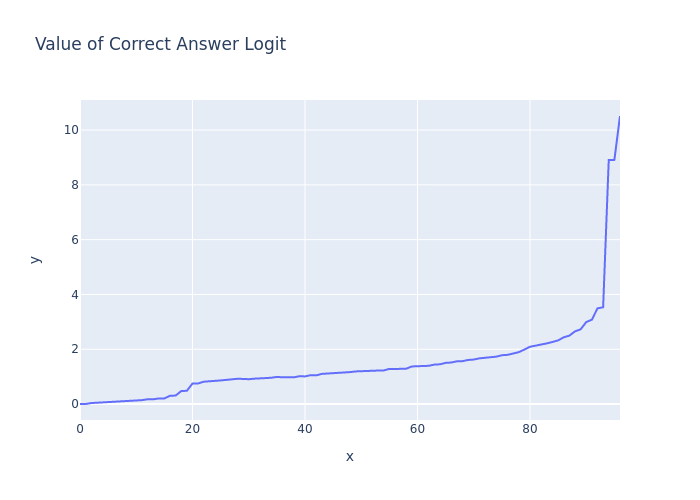

In [51]:
# Returns the accumulated residual stream at each layer/sub-layer and apply_ln applies final layer norm
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, apply_ln=True, return_labels=True
)
print(accumulated_residual.shape)

#Project each layer residual at last token onto vocab space
projection_vocab = einsum("layer d_model, d_model d_vocab --> layer d_vocab", accumulated_residual[:,prompt_num,:], model.W_U)


line(
    projection_vocab[:,answers_tokens.flatten()[prompt_num]].flatten(),
    hover_name=labels,
    title="Value of Correct Answer Logit",
)


### Look at top 1 token of projected residual stream and associated logit value

In [52]:
from matplotlib import pyplot as plt
import numpy as np


# Returns the accumulated residual stream at each layer/sub-layer and apply_ln applies final layer norm
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, apply_ln=True, return_labels=True
)
print(accumulated_residual.shape)

# Project each layer and each position onto vocab space
projection_vocab = einsum("layer pos d_model, d_model d_vocab --> layer pos d_vocab", accumulated_residual[:,0,:,:], model.W_U)

print(projection_vocab.shape)

# Get maximum logit at each layer
max_logit, max_index = projection_vocab.max(-1)

# Convert max index tokens to strings
top_preds = [model.to_str_tokens(layer) for layer in max_index]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(max_logit.cpu(), annot=top_preds, fmt = '', cmap='hot')

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.28 GiB. GPU 0 has a total capacty of 44.35 GiB of which 1.05 GiB is free. Including non-PyTorch memory, this process has 43.28 GiB memory in use. Of the allocated memory 41.27 GiB is allocated by PyTorch, and 1.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [53]:
decomposed_residual, labels = cache.decompose_resid(
    layer=-1, apply_ln=True, return_labels=True
)

# Project each layer and each position onto vocab space
correct_dot = einsum("layer pos d_model, d_model --> layer pos", decomposed_residual[:,prompt_num,:,:], model.W_U[:, answers_tokens.flatten()[prompt_num]])


line(
    correct_dot[:, -1].flatten(),
    hover_name=labels,
    x=labels,
    title="Component Contribution to Correct Answer Logit",
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.31 GiB. GPU 0 has a total capacty of 44.35 GiB of which 1.05 GiB is free. Including non-PyTorch memory, this process has 43.28 GiB memory in use. Of the allocated memory 41.27 GiB is allocated by PyTorch, and 1.71 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Get the specific components that contribute most

In [ ]:
for i, x in enumerate(correct_dot[:,-1].topk(10).indices):
   print(i, labels[x], correct_dot[x,-1].item())

0 13_attn_out 2.1737051010131836
1 17_attn_out 2.030968427658081
2 21_mlp_out 1.8970786333084106
3 20_mlp_out 1.6212023496627808
4 16_mlp_out 1.5243083238601685
5 15_attn_out 1.4860551357269287
6 21_attn_out 1.4415091276168823
7 19_mlp_out 1.3836383819580078
8 14_attn_out 1.1006298065185547
9 10_attn_out 0.9858373403549194


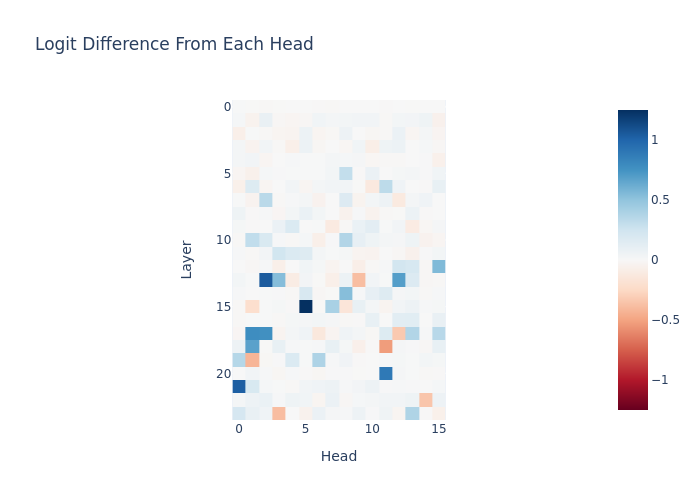

In [ ]:
# Get head residuals
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, apply_ln=True, return_labels=True
)

# Get the dot product of these with correct answer token
per_head_dot = einsum("head d_model, d_model -> head", per_head_residual[:,prompt_num,:], model.W_U[:,answer_tokens.flatten()[prompt_num]])

# Store top 10 heads
top_heads = per_head_dot.topk(10).indices

# Rearrange for plotting\
per_head_dot = einops.rearrange(
    per_head_dot,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    per_head_dot,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
)

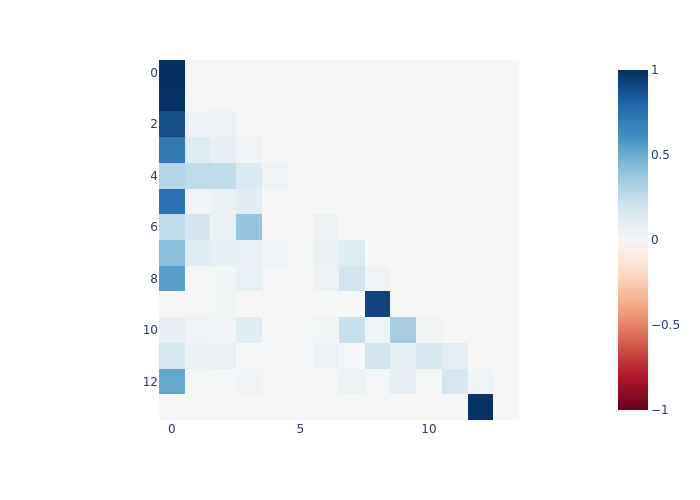

Layer 15, Head 5
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


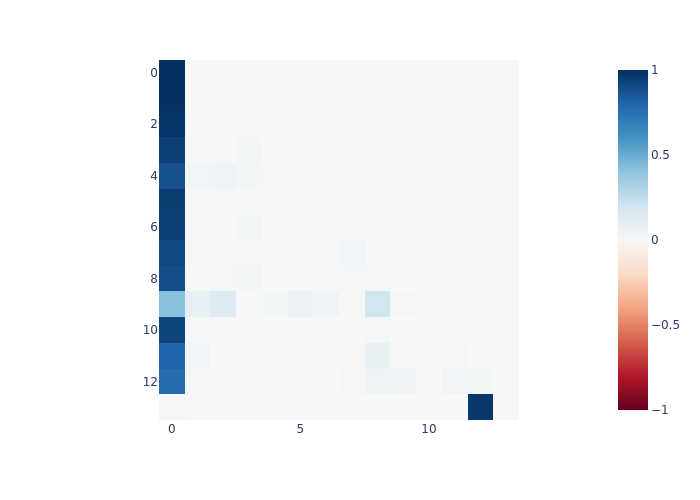

Layer 13, Head 2
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


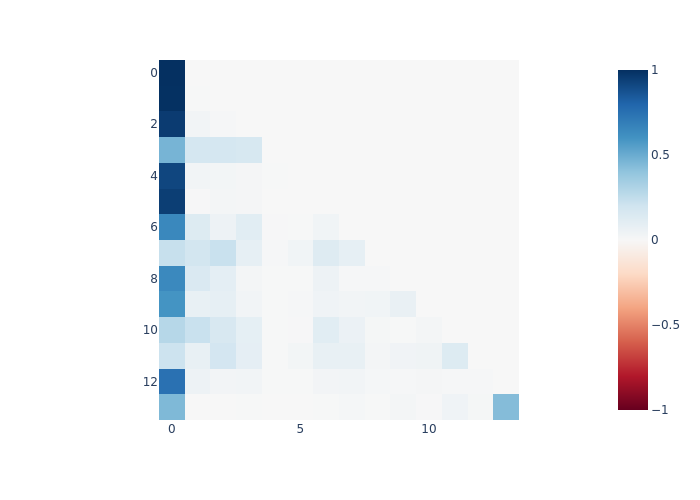

Layer 21, Head 0
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


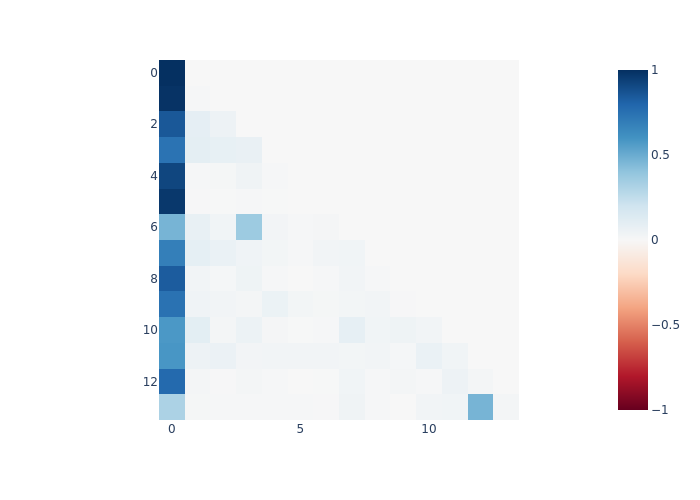

Layer 20, Head 11
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


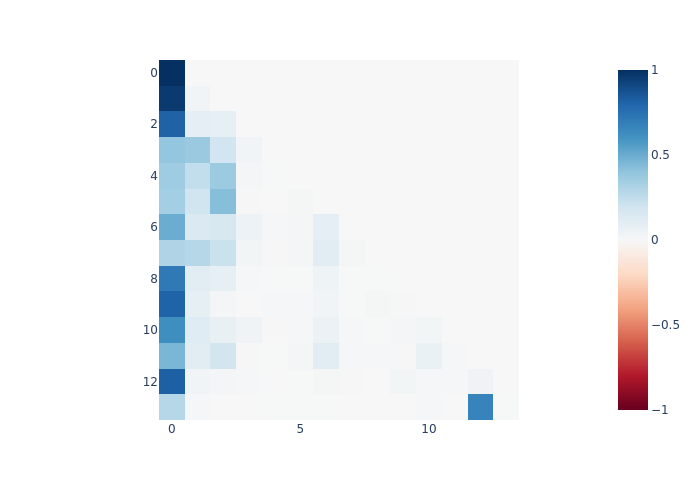

Layer 17, Head 1
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


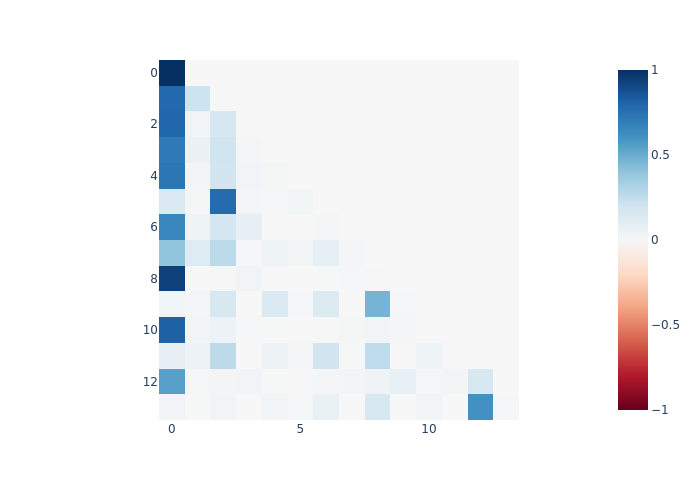

Layer 17, Head 2
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


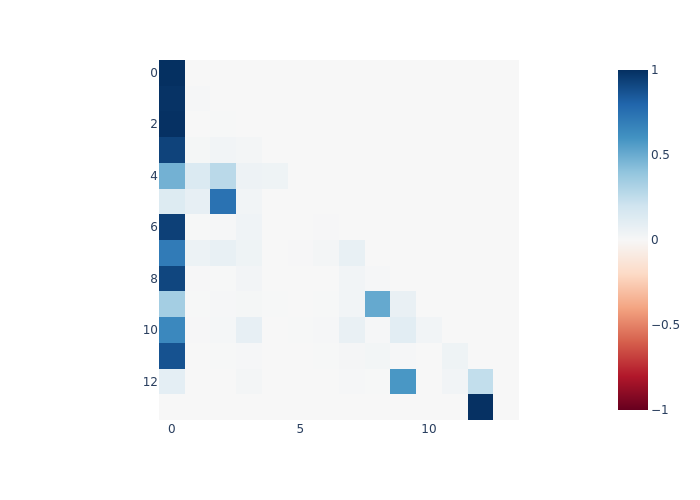

Layer 13, Head 12
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


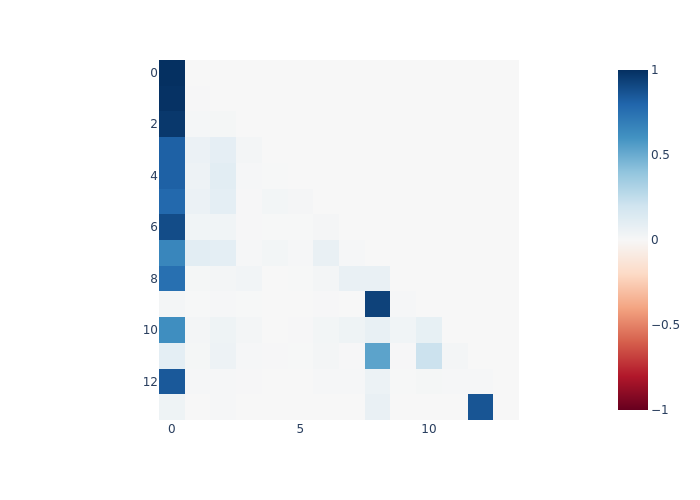

Layer 18, Head 1
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


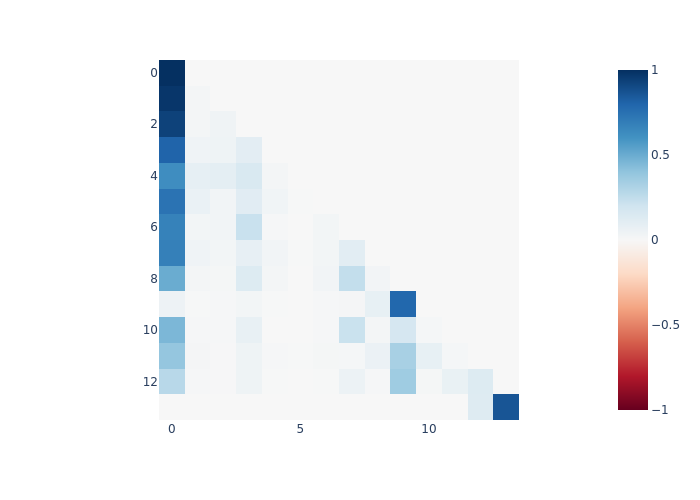

Layer 12, Head 15
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


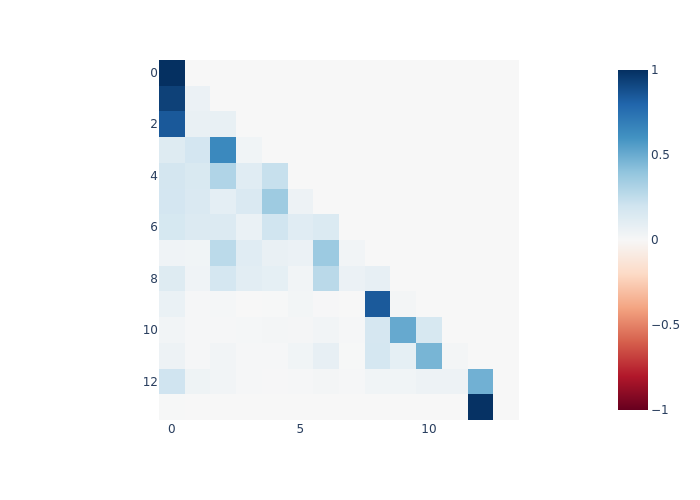

Layer 13, Head 3
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


In [ ]:
for i in range(10):
    layer = top_heads[i]//model.cfg.n_heads
    index = top_heads[i]%model.cfg.n_heads
    imshow(cache[f'blocks.{layer}.attn.hook_pattern'][prompt_num][index])
    labels={"x": "Head", "y": "Layer"}
    print(f"Layer {layer}, Head {index}")
    print(model.to_str_tokens(tokens[prompt_num]))

# Looking at the top MLPs

In [ ]:
# Print the prompt
print(model.to_str_tokens(tokens[prompt_num]))

# Taken from figure
top_mlp_layers = [16, 20, 21]

# Iterate over top contributing MLP Layers
for layer in top_mlp_layers:
    # For each layer, get the top contributing neurons
    neuron_contr = einsum('d_mlp d_model, d_model -> d_mlp', model.blocks[layer].mlp.W_out.detach(), model.W_U[:,answer_tokens.flatten()[prompt_num]])
    top_neurons = neuron_contr.topk(10).indices

    # Project the top contributing neurons onto the vocab space
    projected_val = einsum('top d_model, d_model d_vocab-> top d_vocab', model.blocks[layer].mlp.W_out[top_neurons, :].detach(), model.W_U)

    print(f"__________{layer}__________")
    for x in range(10):
        # Print the vocab projection of the top contributing neurons
        print("Neuron: ", top_neurons[x].item(), "Contribution: ",neuron_contr[top_neurons[x]].item())
        print(model.to_str_tokens(projected_val[x, :].topk(10).indices))
              

['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']
__________16__________
Neuron:  1643 Contribution:  3.348935842514038
[' inability', ' insufficient', 'failed', ' ineffective', ' failed', ' failures', ' unable', ' lackluster', ' lacks', ' lose']
Neuron:  591 Contribution:  2.997021436691284
['National', 'Ent', 'Strong', 'Individual', 'Member', 'Hall', 'Elect', 'Church', 'Trans', 'Tax']
Neuron:  2924 Contribution:  2.8960635662078857
[' negatively', 'appropriately', ' cautiously', ' differently', ' creatively', ' responsibly', ' objectively', ' wisely', ' positively', ' offensively']
Neuron:  486 Contribution:  2.8068737983703613
[' ardu', ' tedious', ' painstaking', ' costly', 'intensive', 'expensive', ' labor', 'cost', ' exhausting', 'requires']
Neuron:  3524 Contribution:  2.6780171394348145
['_', '@', 'kid', 'boss', 'Mex', 'Mc', 'oft', '1992', 'Dr', '1986']
Neuron:  3950 Contribution:  2.586076498031616
['prem', 'dec', 'positive

# Looking at Function Vectors Causal Impact

In [ ]:
# Zero shot prompt
prompt = "increase:"

# Retrieve Function Vectors
FV = np.load("Antonym_FV.npy", allow_pickle=True)

# Find the layer of most impact


In [ ]:
# 